<a href="https://colab.research.google.com/github/krajak09/Master-Thesis/blob/main/scripts/FilterStochVol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=0d8a4c550d87b28168355980c9dd30e193060e3b1b2fb90e9d79ba1b9f9c69ee
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [2]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt

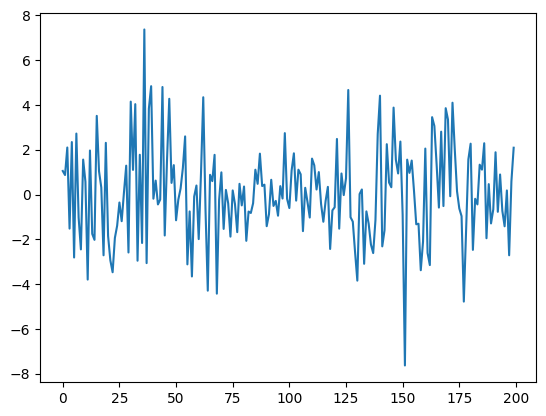

In [3]:
vars = np.sin(np.linspace(0,10, 200))+2
ys = stats.norm.rvs(loc = 0, scale= vars, size= 200)
plt.plot(ys)

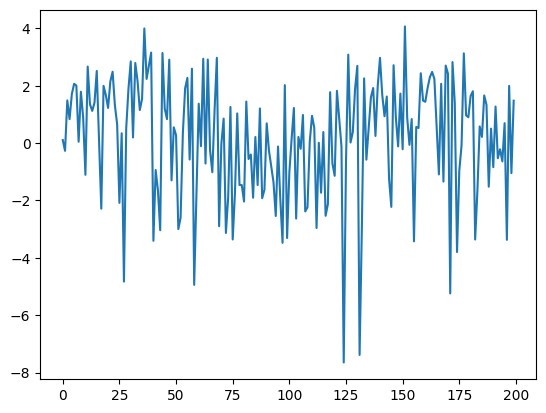

In [4]:
log_ys2 = np.log(ys**2) #X_1^2 chi quadrat
plt.plot(log_ys2)

State: $[h_t, 1]^t$

Transition matrix $\begin{bmatrix} \phi & \mu(1-\phi) \\ 0 & 1 \end{bmatrix}$

Measurement function $[1,-1.27]$

In [5]:
def filter_stoch_vol(returns, mu, phi, sigma2_omega):
  f = KalmanFilter (dim_x=2, dim_z=1)
  f.x = np.array([0.0, 1.0])
  f.F = np.array([[phi,mu*(1-phi)],
                [0.,1.]])
  f.H = np.array([[1.,-1.27]])

  # Initial covariance
  f.P = np.array([[1.0,    0.],
                [   0., 0.0] ])

  # Process Noise
  f.Q = np.array([[sigma2_omega,    0.],
                [   0., 0.0] ])

  f.R = (np.pi**2)/2

  filtered_state = []
  filtered_obs = []

  log_sq_returns = np.log(returns**2)

  for z in log_sq_returns:
    f.predict()
    f.update(z)
    filtered_state.append(f.x)
    filtered_obs.append(f.measurement_of_state(f.x))

  return filtered_state, filtered_obs

In [6]:
mu = 1.0
phi = 1.0
sigma2_omega = 1.0

filtered_hts, filtered_log_ys2 = filter_stoch_vol(ys, mu, phi, sigma2_omega)

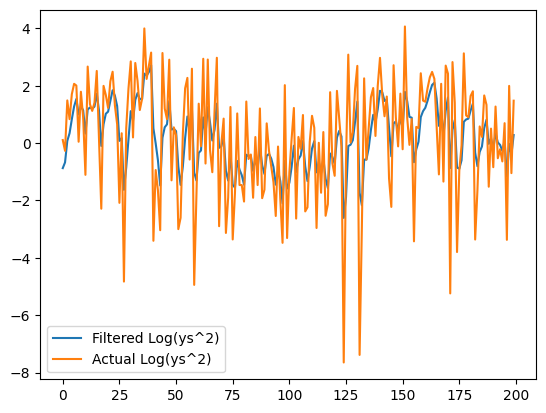

In [7]:
plt.plot([x[0] for x in filtered_log_ys2], label='Filtered Log(ys^2)')
plt.plot(np.log(ys**2), label='Actual Log(ys^2)')
plt.legend()

In [8]:
def predict_stoch_vol(returns, mu, phi, sigma2_omega):
  f = KalmanFilter (dim_x=2, dim_z=1)
  f.x = np.array([0.0, 1.0])
  f.F = np.array([[phi,mu*(1-phi)],
                [0.,1.]])
  f.H = np.array([[1.,-1.27]])

  # Initial covariance
  f.P = np.array([[1.0,    0.],
                [   0., 0.0] ])

  # Process Noise
  f.Q = np.array([[sigma2_omega,    0.],
                [   0., 0.0] ])

  f.R = (np.pi**2)/2

  mse_total = 0.0
  error_list = []

  log_sq_returns = np.log(returns**2)

  for z in log_sq_returns:
    f.predict()
    mse = (f.measurement_of_state(f.x) - z)**2
    mse_total += mse
    error_list.append(mse)
    f.update(z)
  return mse_total, error_list

In [9]:
mu = 0.0
phi = 1.0
sigma2_omega = 0.1

mse, error_list = predict_stoch_vol(ys, mu, phi, sigma2_omega)
mse

array([856.5662014])

In [10]:
def make_energy_stoch_vol(returns):

  def energy_fun(theta):
    mu = theta[0]
    phi = theta[1]
    sigma2_omega = np.exp(theta[2]) #sigma needs to be non-negative

    f = KalmanFilter (dim_x=2, dim_z=1)
    f.x = np.array([0.0, 1.0])
    f.F = np.array([[phi,mu*(1-phi)],
                  [0.,1.]])
    f.H = np.array([[1.,-1.27]])

    # Initial covariance
    f.P = np.array([[1.0,    0.],
                  [   0., 0.0] ])

    # Process Noise
    f.Q = np.array([[sigma2_omega,    0.],
                  [   0., 0.0] ])

    f.R = (np.pi**2)/2

    score = 0.0

    log_sq_returns = np.log(returns**2)

    for z in log_sq_returns:
      f.predict()
      f.update(z)
      score += f.log_likelihood
    return -score

  return energy_fun

In [11]:
energy_fun = make_energy_stoch_vol(ys)

In [12]:
theta0 = np.array([1.0,1.0,np.log(0.1)])
res = opt.minimize(energy_fun, theta0)

In [13]:
def fit_and_predict_stoch_vol(returns):
  # Fit maximum likelihood
  energy_fun = make_energy_stoch_vol(returns)
  theta0 = np.array([0.0,0.0,np.log(1.0)])
  res = opt.minimize(energy_fun, theta0)

  # Compute MSE for fitted model
  mu = res.x[0]
  phi = res.x[1]
  sigma2_omega = np.exp(res.x[2])
  mse, error_list = predict_stoch_vol(returns, mu, phi, sigma2_omega)
  filtered_states, filtered_obs = filter_stoch_vol(returns, mu, phi, sigma2_omega)
  return res, mse, error_list, filtered_states, filtered_obs

In [14]:
res, mse, error_list, filtered_states, filtered_obs = fit_and_predict_stoch_vol(ys)

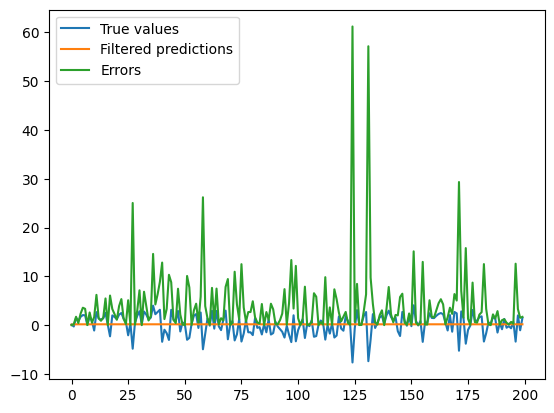

In [15]:
# Fitted model
plt.plot(np.log(ys**2), label="True values")
plt.plot(filtered_obs, label="Filtered predictions")
plt.plot(error_list, label="Errors")
plt.legend()